In [2]:
import pandas as pd


In [3]:
full_data = pd.read_csv('weatherAUS.csv')
full_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [4]:
full_data.shape


(21305, 24)

In [5]:
full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21305 entries, 0 to 21304
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           21305 non-null  object 
 1   Location       21305 non-null  object 
 2   MinTemp        20982 non-null  float64
 3   MaxTemp        21129 non-null  float64
 4   Rainfall       21083 non-null  float64
 5   Evaporation    7360 non-null   float64
 6   Sunshine       4778 non-null   float64
 7   WindGustDir    17893 non-null  object 
 8   WindGustSpeed  17895 non-null  float64
 9   WindDir9am     18515 non-null  object 
 10  WindDir3pm     19609 non-null  object 
 11  WindSpeed9am   20762 non-null  float64
 12  WindSpeed3pm   20088 non-null  float64
 13  Humidity9am    20949 non-null  float64
 14  Humidity3pm    20259 non-null  float64
 15  Pressure9am    17901 non-null  float64
 16  Pressure3pm    17898 non-null  float64
 17  Cloud9am       11919 non-null  float64
 18  Cloud3

In [6]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

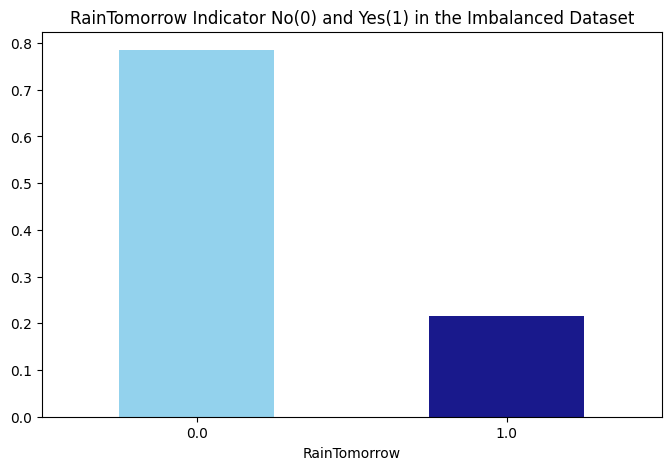

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

Handling Class Imbalance For Rainfall Prediction

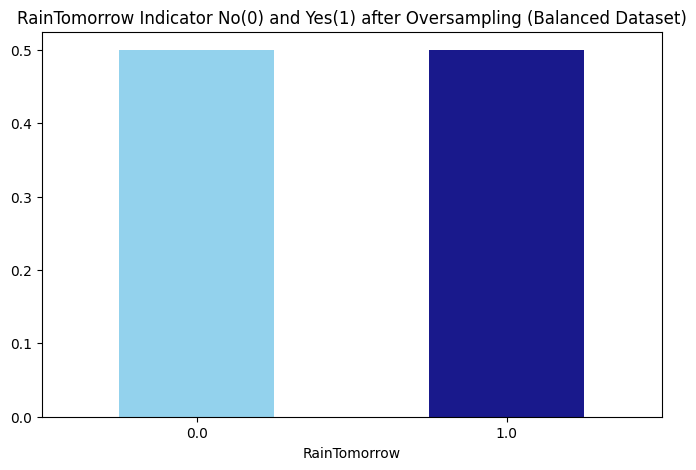

In [8]:
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

<Axes: >

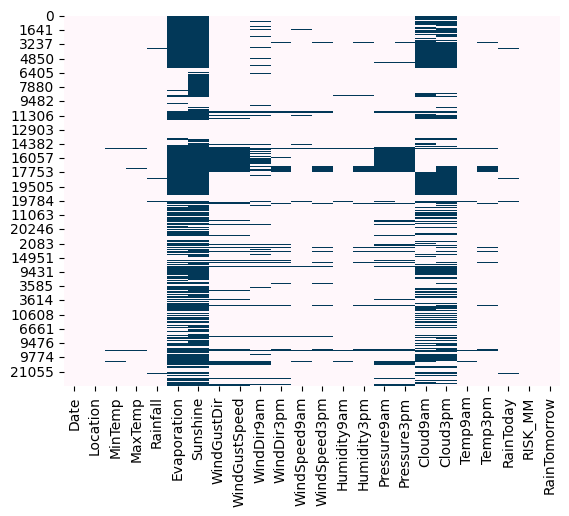

In [9]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [10]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,25898,0.774230
Evaporation,22380,0.669058
Cloud3pm,14657,0.438176
Cloud9am,14190,0.424215


In [11]:
oversampled.select_dtypes(include=['object']).columns


Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [12]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [13]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [14]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [15]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1568.000000
Location            4.000000
MinTemp             8.800000
MaxTemp             8.500000
Rainfall            2.600000
Evaporation         4.049276
Sunshine            5.740314
WindGustDir         7.000000
WindGustSpeed      17.507395
WindDir9am          8.000000
WindDir3pm          7.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        33.000000
Pressure9am         7.200000
Pressure3pm         7.200000
Cloud9am            4.035240
Cloud3pm            3.692698
Temp9am             7.800000
Temp3pm             8.100000
RainToday           1.000000
RISK_MM             6.200000
RainTomorrow        1.000000
dtype: float64


In [16]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(23218, 24)

<Axes: >

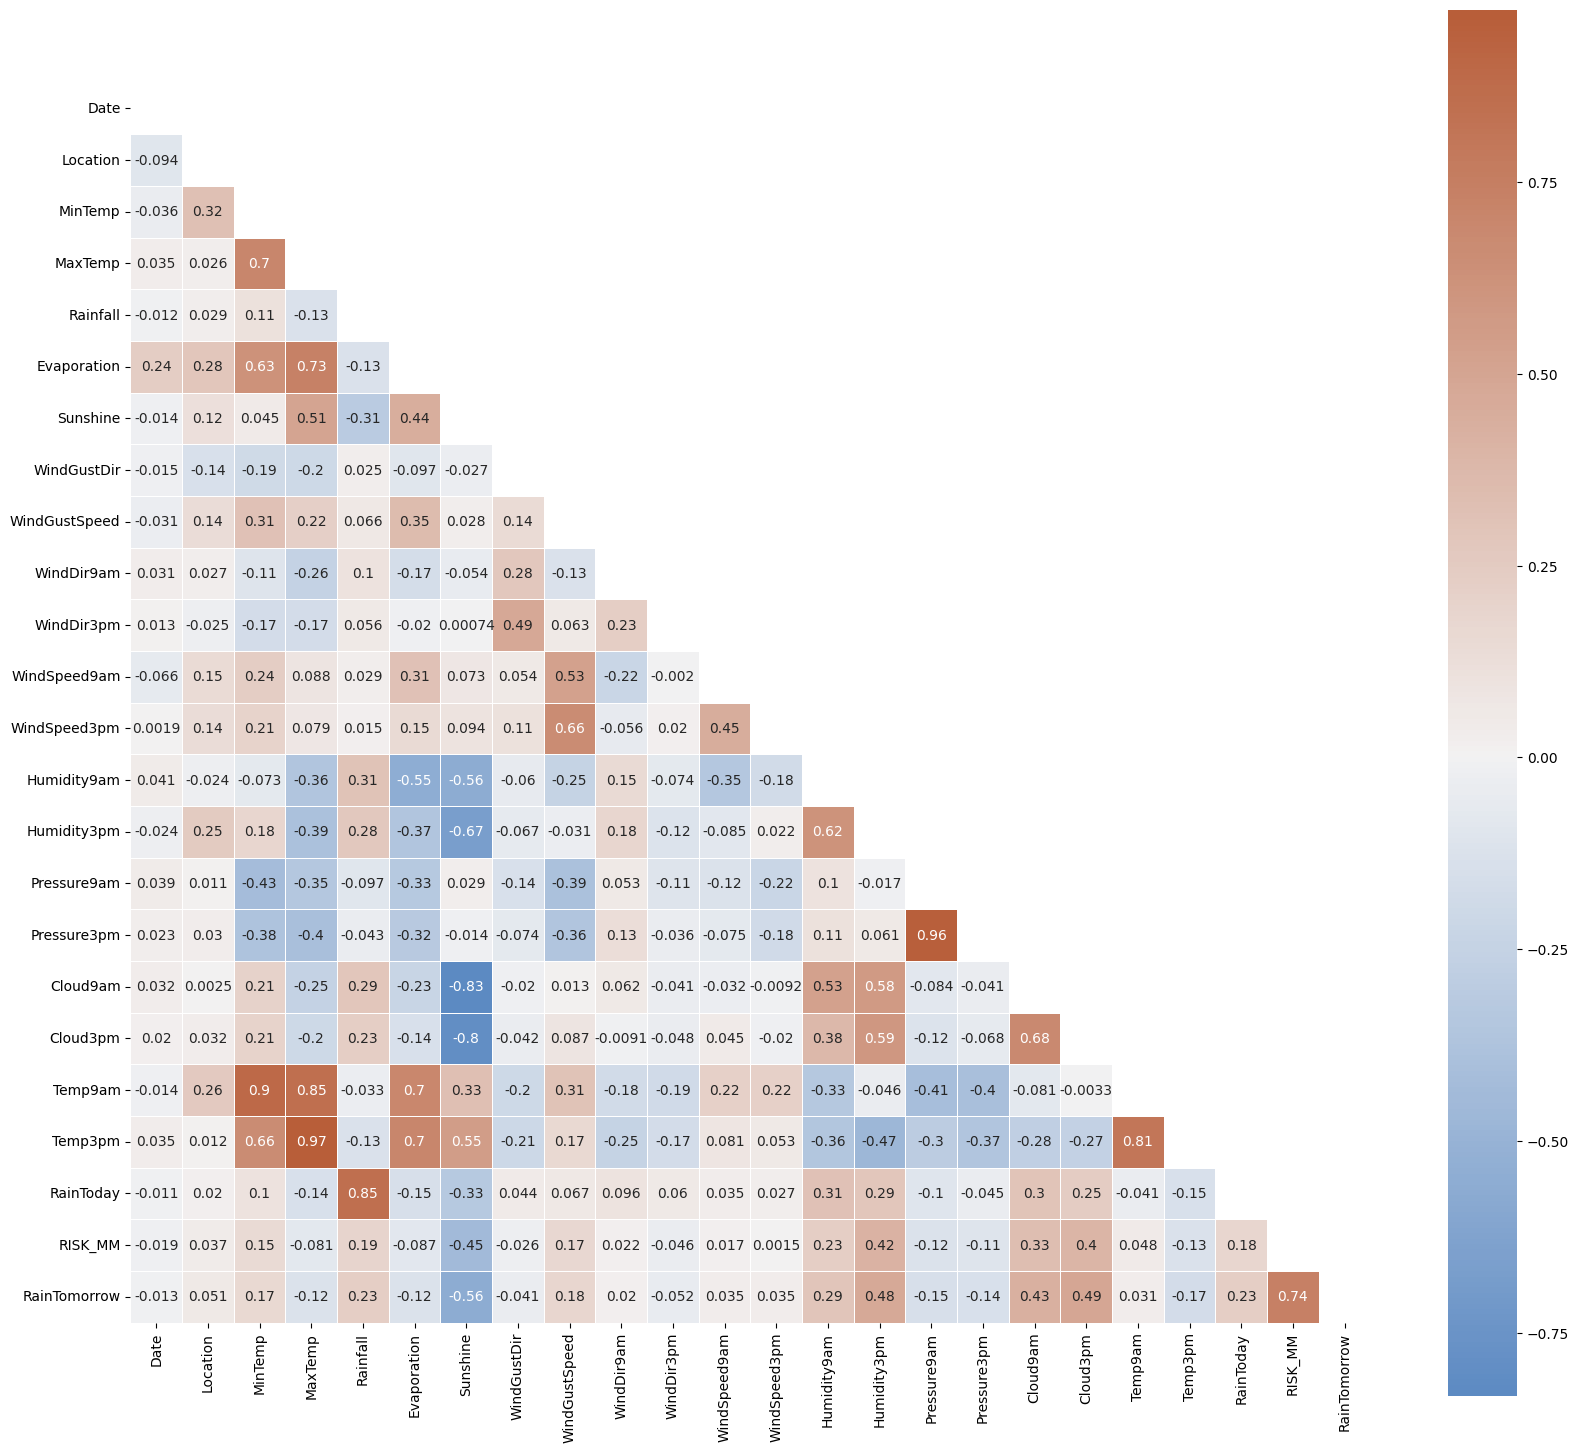

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
# Use bool instead of np.bool
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

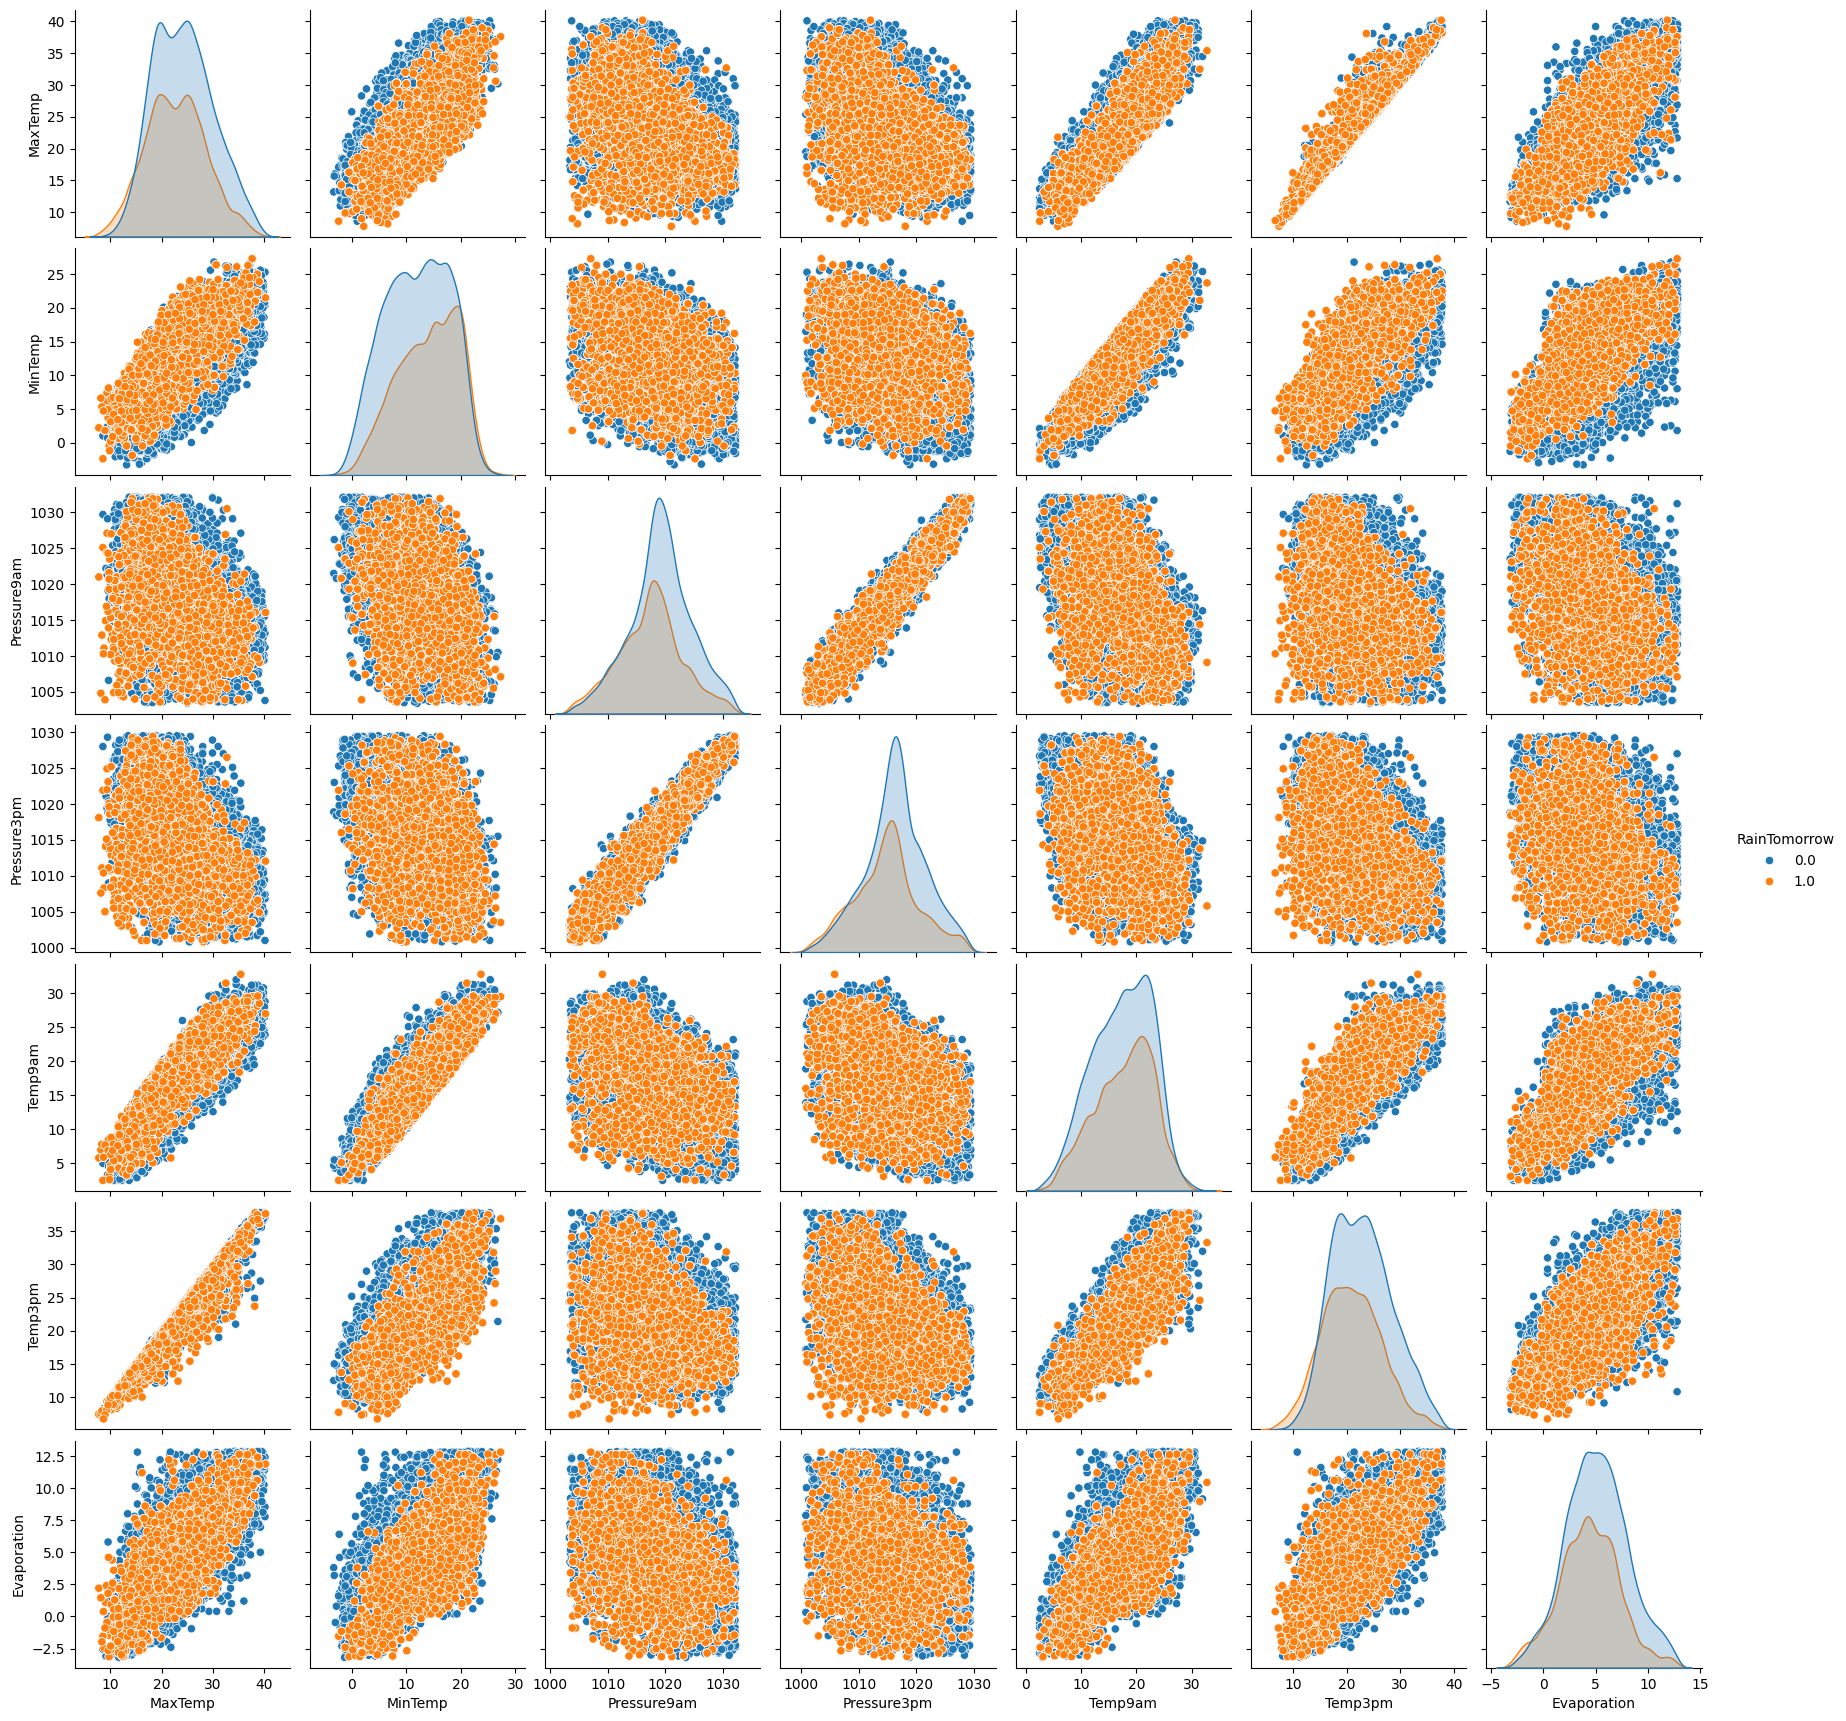

In [20]:
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )


In [21]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [22]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


In [23]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00413824 0.00339335 0.00581984 0.00523092 0.00715663 0.003942
 0.09159028 0.00320698 0.01134425 0.00263778 0.00380279 0.00279194
 0.00389331 0.01516933 0.03655451 0.00634144 0.00762736 0.02870647
 0.05635603 0.00498603 0.00572121 0.0034608  0.68612852]
